## *Elliott Rose - 300540768*
________

## Imports

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import random
import shutil
import torch.nn as nn 
import torch.optim as optim

from collections import defaultdict
from torchvision.io import read_image
from torchvision.transforms import transforms
from torchvision import datasets
from PIL import Image, ImageEnhance
from collections import Counter
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler

_____________

## Loading images

In [2]:
current_directory = os.getcwd()
train_data_dir = os.path.abspath(os.path.join(current_directory, "..", "train_data"))
cherry_images_dir = os.path.abspath(os.path.join(current_directory, "..", "train_data/cherry"))
strawberry_images_dir = os.path.abspath(os.path.join(current_directory, "..", "train_data/strawberry"))
tomato_images_dir = os.path.abspath(os.path.join(current_directory, "..", "train_data/tomato"))

#transforms images to tensors
transform = transforms.Compose([transforms.ToTensor()])
data = datasets.ImageFolder(root=train_data_dir, transform=transform)

__________

## EDA

Unique Image Shapes: {(168, 300, 3), (193, 262, 3), (300, 300, 3), (169, 299, 3), (167, 301, 3), (229, 220, 3), (182, 277, 3), (199, 254, 3), (225, 225, 3), (203, 249, 3), (232, 217, 3), (194, 259, 3), (230, 219, 3), (163, 310, 3), (211, 238, 3), (236, 214, 3), (193, 261, 3), (168, 301, 3), (199, 253, 3), (197, 256, 3), (283, 178, 3), (900, 870, 3), (278, 181, 3), (183, 275, 3), (228, 221, 3), (276, 183, 3), (251, 201, 3), (234, 215, 3), (277, 182, 3), (279, 181, 3), (138, 366, 3), (957, 800, 3)}
File Formats: {'jpg'}
Class Distribution: Counter({'cherry': 1495, 'strawberry': 1495, 'tomato': 1495})


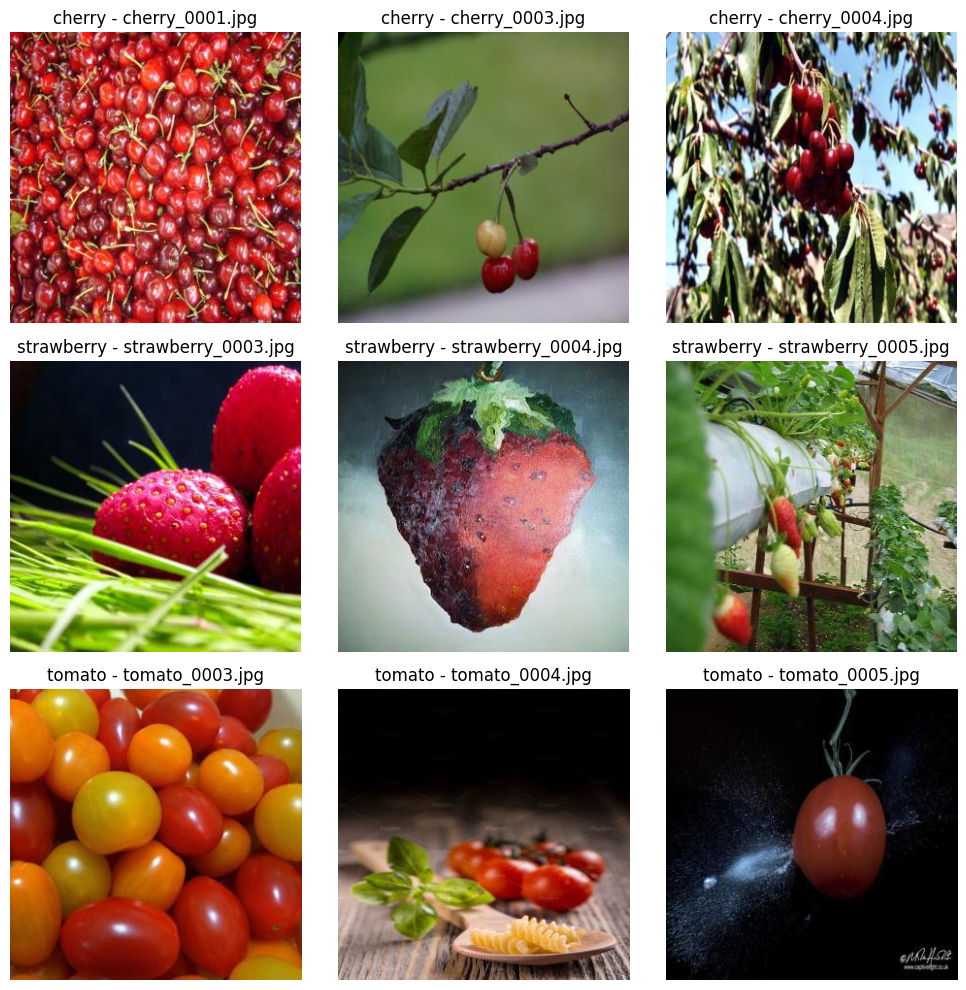

In [55]:
# Paths to each image folder

train_data_folders = {
    "cherry": cherry_images_dir,
    "strawberry": strawberry_images_dir,
    "tomato": tomato_images_dir,
}

# Load images and get their shapes from multiple directories
def load_images(folders):
    image_shapes = []
    file_formats = []
    class_counts = Counter()
    images_by_class = {class_name: [] for class_name in folders.keys()}
    
    for class_name, folder in folders.items():
        if not os.path.isdir(folder):
            print(f"Directory not found: {folder}")
            continue

        # Filter for image files in the current folder
        image_files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
        
        for image_file in image_files:
            # Load image using OpenCV
            image_path = os.path.join(folder, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image_shapes.append(image.shape)
                file_formats.append(image_file.split('.')[-1])
                
                # Store the image path for the specific class
                images_by_class[class_name].append(image_path)
                
                # Count class occurrences
                class_counts[class_name] += 1
    
    return image_shapes, file_formats, class_counts, images_by_class

# Get image information from all folders
image_shapes, file_formats, class_counts, images_by_class = load_images(train_data_folders)

# Inspecting Image Dimensions
print("Unique Image Shapes:", set(image_shapes))

# Check File Formats
print("File Formats:", set(file_formats))

# Class Distribution
print("Class Distribution:", class_counts)

# Visualize First 3 Images from Each Class
plt.figure(figsize=(10, 10))
for i, (class_name, image_paths) in enumerate(images_by_class.items()):
    for j, image_path in enumerate(image_paths[:3]):  # Display first 3 images of each class
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name} - {os.path.basename(image_path)}")
        plt.axis('off')

plt.tight_layout()
plt.show()

________

## Pre-processing 

* Filtering images based on dimensionality 

In [59]:
# Initialize a counter for dimensions and a counter for moved images
dimension_counter = Counter()
moved_images_count = 0

# Creating a directory for unwanted images
unwanted_dir = os.path.join(train_data_dir, 'unwanted') 
os.makedirs(unwanted_dir, exist_ok=True)

# Recursively iterate through the subdirectories, look at every image and count the dimensions
for root, dirs, files in os.walk(train_data_dir):
    for filename in files:
        if filename.endswith(".jpg"):
            img_path = os.path.join(root, filename)
            with Image.open(img_path) as img:
                width, height = img.size
                dimension_counter[(width, height)] += 1

# Find the most common dimensions
mode_dimensions = dimension_counter.most_common()[0][0]

print(f"Chosen dimensions for kept images: {mode_dimensions}")

# Recursively iterate through the subdirectories again to filter the incorrectly sized images
for root, dirs, files in os.walk(train_data_dir):
    # Skip the 'unwanted' directory
    if root == unwanted_dir:
        continue
    for filename in files:
        if filename.endswith(".jpg"):
            img_path = os.path.join(root, filename)
            with Image.open(img_path) as img:
                width, height = img.size
            if (width, height) != mode_dimensions:
                shutil.move(img_path, os.path.join(unwanted_dir, filename))
                moved_images_count += 1  

# Print the total number of moved images
print(f"Total images moved to 'unwanted' directory: {moved_images_count}")


Chosen dimensions for kept images: (300, 300)
Total images moved to 'unwanted' directory: 53


Ran into some issues with permissions. Quick double check that permisssion is granted to save files in the directory

In [67]:
def check_write_permission(directory):
    try:
        # Creating temporary file name
        test_file_path = os.path.join(directory, 'test_permission.txt')
        
        # Try to create and write to the file
        with open(test_file_path, 'w') as test_file:
            test_file.write("This is a test file to check write permission.")
        
        # If successful, remove the test file
        os.remove(test_file_path)
        print(f"Write permission is granted for directory: {directory}")
    except Exception as e:
        print(f"Write permission is denied for directory: {directory}. Error: {e}")

test_directory = cherry_images_dir  
check_write_permission(test_directory)


Write permission is granted for directory: c:\Users\ellio\repo\COMP309\assignment5\train_data\cherry


* Converting image modes (RGBA & Grayscale -> RGB)
* Augmenting images and saving them to correct directory

In [27]:
def apply_random_augmentation(img):
    # Choose a random augmentation
    augmentation_type = random.choice(['rotate', 'flip', 'color_variation'])

    if augmentation_type == 'rotate':
        # Rotate by a random choice of 90, 180, or 270 degrees
        img = img.rotate(random.choice([90, 180, 270]))
    elif augmentation_type == 'flip':
        # Randomly flip horizontally or vertically
        if random.choice([True, False]):
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        else:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
    elif augmentation_type == 'color_variation':
        # Apply random color enhancement
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(random.uniform(0.5, 2.0))
    
    return img

def process_and_augment_images(train_data_dir):
    # Define the subdirectories for cherry, strawberry, and tomato
    subdirectories = ['cherry', 'strawberry', 'tomato']
    augmentation_suffix = "_aug"

    # Iterate over each subdirectory
    for sub_dir in subdirectories:
        # Define the path to the current subdirectory
        dir_path = os.path.join(train_data_dir, sub_dir)
        
        # Process each image in the subdirectory
        for filename in os.listdir(dir_path):
            if filename.endswith(".jpg"):
                file_path = os.path.join(dir_path, filename)

                # Open the image and check its mode
                with Image.open(file_path) as img:
                    if img.mode == 'RGBA':
                        img = img.convert('RGB')
                    elif img.mode == 'L':  # Grayscale
                        img = img.convert('RGB')
                    
                    # Apply a random augmentation
                    img = apply_random_augmentation(img)

                    # Save the augmented image with the `_aug` suffix
                    new_filename = filename.replace(".jpg", f"{augmentation_suffix}.jpg")
                    img.save(os.path.join(dir_path, new_filename), format="JPEG")

In [4]:
# Only run if you want more images for training purposes!
# Do not use too many times otherwise the training data will get over populated.

#process_and_augment_images(train_data_dir)

* Creating dataset 

In [11]:
# Define a transformation (if needed), here simply converting to tensor
transform = transforms.ToTensor()

# Create the dataset using DatasetFolder
# Treat each subdirectory as a separate class
dataset = datasets.DatasetFolder(
    root=train_data_dir,
    loader=lambda x: Image.open(x).convert("RGB"),  
    extensions=(".jpg",),
    transform=transform
)

# Dictionary to store counts of each unique size
size_counts = defaultdict(int)

# Iterate over the dataset to calculate unique sizes
for i in range(len(dataset)):
    image, label = dataset[i]
    size_counts[image.size()] += 1  # Increment the count for this image size

# Print the results
print(f"Total images in dataset: {len(dataset)}")
print("Unique image sizes and their counts:")
for size, count in size_counts.items():
    print(f"Size {size}: {count} images")

Total images in dataset: 8917
Unique image sizes and their counts:
Size torch.Size([3, 300, 300]): 8864 images
Size torch.Size([3, 230, 219]): 1 images
Size torch.Size([3, 169, 299]): 1 images
Size torch.Size([3, 229, 220]): 2 images
Size torch.Size([3, 193, 261]): 2 images
Size torch.Size([3, 225, 225]): 18 images
Size torch.Size([3, 183, 275]): 3 images
Size torch.Size([3, 278, 181]): 1 images
Size torch.Size([3, 251, 201]): 2 images
Size torch.Size([3, 234, 215]): 1 images
Size torch.Size([3, 279, 181]): 1 images
Size torch.Size([3, 168, 300]): 1 images
Size torch.Size([3, 228, 221]): 1 images
Size torch.Size([3, 193, 262]): 1 images
Size torch.Size([3, 167, 301]): 1 images
Size torch.Size([3, 276, 183]): 1 images
Size torch.Size([3, 211, 238]): 1 images
Size torch.Size([3, 138, 366]): 1 images
Size torch.Size([3, 163, 310]): 1 images
Size torch.Size([3, 182, 277]): 1 images
Size torch.Size([3, 236, 214]): 1 images
Size torch.Size([3, 277, 182]): 1 images
Size torch.Size([3, 199, 25

* Pruning dataset for anything that's not torch.Size([3, 300, 300])

In [12]:
def filter_dataset_by_size(dataset, target_size=torch.Size([3, 300, 300])):
    # Filtered dataset to hold images of the desired size
    filtered_dataset = []
    
    for i in range(len(dataset)):
        image, label = dataset[i]
        if image.size() == target_size:
            filtered_dataset.append((image, label))
    
    print(f"Filtered dataset contains {len(filtered_dataset)} images of size {target_size}")
    return filtered_dataset

# Filter the dataset by the specified size
dataset = filter_dataset_by_size(dataset)


Filtered dataset contains 8864 images of size torch.Size([3, 300, 300])


_______________

## Train/test split

In [13]:
torch.manual_seed(8008135)

train_proportion = 0.9
test_proportion = 0.1
total_samples = len(dataset)
train_size = int(train_proportion * total_samples)
test_size = total_samples - train_size

# Indexes of every image 
indices = list(range(total_samples))

# Random split of indexes 
train_indices, test_indices = random_split(indices, [train_size, test_size])

batch_size = 64

# Gets training data 
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

# Gets testing data
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

_______

## MLP

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__() # Correctly call the parent class's __init__
        self.fc1 = nn.Linear(input_size, hidden_size) # First linear layer
        self.relu = nn.ReLU() # Activation function which adds non inearity
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [15]:
# Initializing model, function, optimizer
input_size = 300*300*3  # Example input size
hidden_size = 5  # Hidden size
num_classes = 3  # Number of classes
learning_rate = 0.01

model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=3e-2)

num_epochs = 10 

for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    for inputs, labels in train_loader:  # Iterate through training data loader
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Print the loss at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

Epoch [1/10], Loss: 1.0992
Epoch [2/10], Loss: 1.0943
Epoch [3/10], Loss: 1.0985
Epoch [4/10], Loss: 1.1025
Epoch [5/10], Loss: 1.0987
Epoch [6/10], Loss: 1.0975
Epoch [7/10], Loss: 1.0978
Epoch [8/10], Loss: 1.0982
Epoch [9/10], Loss: 1.0994
Epoch [10/10], Loss: 1.0985
Training complete


In [16]:
# Define function for testing
def test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation during testing
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get class with the highest probability
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = 100 * total_correct / total_samples
    return accuracy

# Define loss function
criterion = nn.CrossEntropyLoss()

# Calling test function to get accuracy
test_accuracy = test(model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 31.91%


___________

## CNN

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers of CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 75 * 75, 128)  # Adjust input size based on image dimensions
        self.dropout = nn.Dropout(0.5)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # Forward pass through the layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.fc1(x)
        x = self.dropout(x) 
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [18]:
# Initialize model, loss function, and optimizer
input_size = 300*300*3  # input size
hidden_size = 7  # hidden size
num_classes = 3  # number of classes
learning_rate = 0.1
num_epochs = 10  

cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate, weight_decay=3e-2)

for epoch in range(num_epochs):
    cnn_model.train()  # Set the model to training mode

    for inputs, labels in train_loader:  # Iterate through the training data loader
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Print the loss at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

Epoch [1/10], Loss: 1.0949
Epoch [2/10], Loss: 1.1111
Epoch [3/10], Loss: 1.0689
Epoch [4/10], Loss: 1.0798
Epoch [5/10], Loss: 1.0373
Epoch [6/10], Loss: 1.0824
Epoch [7/10], Loss: 0.9500
Epoch [8/10], Loss: 0.9685
Epoch [9/10], Loss: 1.0686
Epoch [10/10], Loss: 1.0840
Training complete


In [19]:
# Define function for testing
def test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation during testing
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get class with the highest probability
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = 100 * total_correct / total_samples
    return accuracy

# Define loss function
criterion = nn.CrossEntropyLoss()

# Call test function to get accuracy
test_accuracy = test(cnn_model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 49.15%
